In [149]:
import pandas as pd
import numpy as np
import re
import sys 
#!{sys.executable} -m pip install contractions
import contractions
import nltk
#!{sys.executable} -m pip install transformers
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [150]:
results1 = pd.read_excel('/Users/symphony/Desktop/Results1.xlsx')
results2 = pd.read_excel('/Users/symphony/Desktop/Results2.xlsx')
df = pd.concat([results1, results2], ignore_index=True)
df = df.drop(['CompletionDate','Amazon voucher winner', '11. Name', '12. SID', 
'5.a. If you selected Other, please specify:'], axis = 1)
df = df.rename(columns={df.columns[0]:'campus', df.columns[1]:'how_became_aware', df.columns[2]:'if_other', 
df.columns[3]:'first_contact', df.columns[4]:'access_method', df.columns[5]:'met_up', df.columns[6]:'how_helped', 
df.columns[7]:'meet_new', df.columns[8]:'friends', df.columns[9]:'suggestions', df.columns[10]:'comments'})
df = df.drop(['if_other'], axis = 1)

In [151]:
df['how_helped']

0      It helps a lot to settle in to life as a stude...
1      Provided information about the uniforms and ma...
2                                          To find notes
3            There wasn’t too much information provided.
4                              They didn't to be honest.
                             ...                        
125    When I was in my first year, i had a lot of an...
126    Assisted me in helping find accomadation, prov...
127                                           Was great 
128    Helped me by answering questions and concerns ...
129    Meet in University, speak about their experien...
Name: how_helped, Length: 130, dtype: object

## Unsupervised method

In [152]:
#In what ways did your Welcome Buddy help you to settle in to life as a student at ARU?

#create function that cleans the text (vocab reduction), tokenizes each word of each response and removes stop words
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
  
df['how_helped'][2]

text = 'we are 100 welcome welcome buddy forever&*^'

def vocab_clean(text):
    #clean text
    text = str(text)#make each entry into a string
    text = text.lower()
    text = contractions.fix(text)  #expand all contractions
    text = re.sub("[\(\[].*?[\)\]]", "", text) #remove () and [] and content inside
    text = re.sub('\w*\d\w*', '', text) #remove digits
    text = re.sub("\W"," ",text) #remove non-letters
    text = re.sub('_+', '', text) #remove underscores
    text = re.sub('-+', '', text) #remove dashes
    text = re.sub(r'[^\w\s]','',text)  #remove quotes, but not what's w/in quote
    text = text.replace('welcome buddy', '') #remove 'welcome buddy' from all responses
    text = text.replace('buddy', '') #remove 'buddy' from all responses
    text = text.replace('welcome buddies', '') #remove 'welcome buddy' from all responses
    text = text.replace('alice', '') #remove 'alice' from all responses
    text = text.replace('emma', '') #remove 'emma' from all responses
    text = text.replace('aru', '') # remove 'aru' from all responses
    text = text.replace('oh', '') # remove 'oh' from all responses
    text = text.replace(' not ', 'not_') #join all 'not' to verb preceeding it
    text = text.replace(' no ', ' no_') #join all "no" to noun following it
    #text = " ".join(re.split("\s+", text)) #remove duplicate spaces   
    #turn each element into a token
    text = word_tokenize(text)
    
    #removal of stop words
    #nltk.download('stopwords')
    stop = stopwords.words('english')
    stop.remove('not')
    stop.remove('no')
    text = [word for word in text if not word in stopwords.words()]
    
    return text

vocab_clean(text)
#apply to whole column and make this into a new column of preprocessed text
df['new_how_helped'] = df['how_helped'].apply(lambda x: vocab_clean(x))

In [153]:
cleaned_text = df['new_how_helped']
cleaned_text = str(cleaned_text)
type(cleaned_text)

str

In [154]:
#sentiment analysis using pre-trained Distilbert
from transformers import pipeline
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)
prediction = classifier(cleaned_text, )
prediction


[[{'label': 'sadness', 'score': 0.013175000436604023},
  {'label': 'joy', 'score': 0.9320977926254272},
  {'label': 'love', 'score': 0.0036559072323143482},
  {'label': 'anger', 'score': 0.040714144706726074},
  {'label': 'fear', 'score': 0.008339018560945988},
  {'label': 'surprise', 'score': 0.0020182207226753235}]]

In [155]:
sentences = df['new_how_helped'].to_list()
len(sentences)

130

In [156]:
#list comprehension to find number of tokens
count = sum([len(i) for i in sentences])
print('Total Number of elements : ', count)

Total Number of elements :  687


In [157]:
#for loop to find vector size, aka number of dimensions of the embedding, 
#e.g. the length of the dense vector to represent each token (word)
count = 0
for i in sentences:
    count += len(i)                    
print('Total Number of tokens : ', count)

Total Number of tokens :  687


In [158]:
#create w2v model
from gensim.models import word2vec
model = word2vec.Word2Vec(sentences, workers=1, size = 350, min_count = 1,
            window = 4, sg = 1, sample = 1e-3)

/Users/symphony/opt/anaconda3/lib/python3.8/site-packages/gensim/models/base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [159]:
#validate results
model.wv.most_similar("helpful")

[('queries', 0.1713251769542694),
 ('fundamentals', 0.142628014087677),
 ('websites', 0.11754798889160156),
 ('knowing', 0.11342263966798782),
 ('got', 0.10422667115926743),
 ('ideas', 0.10284942388534546),
 ('term', 0.10252537578344345),
 ('wasnot_anything', 0.10194487869739532),
 ('nothing', 0.10157476365566254),
 ('hard', 0.09795626997947693)]

In [160]:
#look at model's learned vocabulary of tokens (words)
words = list(model.wv.vocab)
print(words)

['helps', 'lot', 'settle', 'life', 'student', 'provided', 'information', 'uniforms', 'made', 'welcome', 'questions', 'find', 'notes', 'wasnot_too', 'much', 'didnot_to', 'honest', 'nan', 'unfortunately', 'introduced', 'time', 'spoke', 'sent', 'friendly', 'email', 'didnot_communicate', 'speak', 'settling', 'answered', 'promptly', 'sure', 'everything', 'okay', 'explained', 'help', 'available', 'new', 'students', 'terms', 'health', 'well', 'helped', 'explain', 'assignments', 'deadlines', 'extensions', 'needed', 'requested', 'required', 'subjects', 'helping', 'university', 'stuff', 'process', 'quiet', 'straight', 'forward', 'navigate', 'canvas', 'wasnot_any', 'conversation', 'told', 'expect', 'andnot_to', 'worry', 'offer', 'person', 'meet', 'wasnot_suitable', 'finding', 'local', 'area', 'revision', 'tips', 'couldnot_attend', 'day', 'didnot_', 'no_effort', 'reach', 'arrange', 'support', 'welcoming', 'nice', 'get', 'know', 'someone', 'older', 'year', 'gave', 'good', 'advice', 'question', 'whe

In [161]:
#review the embedded vector for a specific token as follows:

print(model['helpful'])

[-6.45259279e-04  4.89443250e-04 -1.35378190e-03  5.21370501e-04
 -1.83394382e-04 -8.21070280e-04  4.10344946e-04  4.26686369e-04
  6.16939040e-04  8.67462295e-05 -1.04847393e-04  1.76538801e-04
  3.72873365e-05 -8.04072770e-04 -7.25147547e-04 -7.71806517e-04
  1.13763544e-03  7.87930447e-04 -1.31378940e-04 -5.37028827e-04
  7.28268642e-04  1.47730854e-04  6.55634562e-04  4.79460286e-05
  4.14493879e-05 -4.13965347e-04  1.27188477e-03 -3.46855726e-04
  3.51496965e-05 -1.12141238e-03 -8.04840020e-05 -3.51705006e-04
  6.62346079e-04  1.00046466e-03 -9.44200554e-04 -4.47880448e-04
 -1.18708564e-03 -2.47176824e-04 -1.06250495e-03 -1.36353646e-03
  1.24192098e-03 -6.11548079e-04  1.42121207e-05  9.75532806e-04
  1.23320462e-03 -1.39535766e-03  6.28123176e-04 -1.19613716e-03
  1.00005977e-03  3.84324987e-04 -2.67162482e-04  3.24332534e-04
  1.49318730e-04 -3.66253895e-04  1.62039301e-04  2.11067032e-04
  1.42983568e-03 -1.25312537e-03 -1.18993048e-03 -1.25092352e-04
 -1.30097975e-03 -1.32399

<ipython-input-161-23d622e8f218>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(model['helpful'])


<ipython-input-162-8db8ecd2a535>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


Text(0.5, 1.0, 'scatterplot PCA projection of word2vec model')

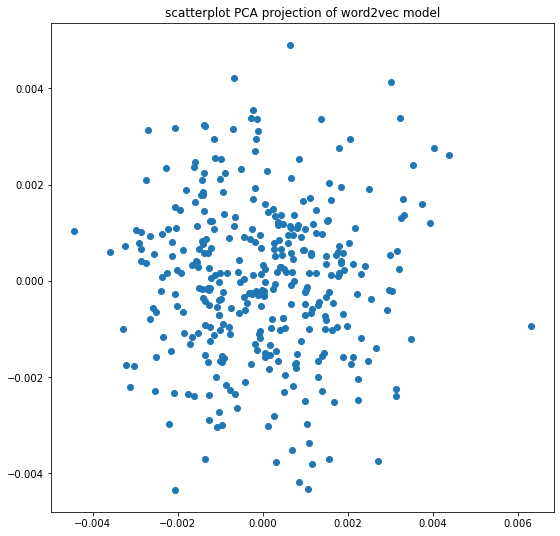

In [162]:
#Visualize Word Embedding
X = model[model.wv.vocab]
#plot vectors w/ pca
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.scatter(result[:, 0], result[:, 1])

plt.gcf().set_size_inches((9, 9)) 

plt.title('scatterplot PCA projection of word2vec model')

#words = list(model.wv.vocab)
#for i, word in enumerate(words):
    #plt.annotate(word, xy=(result[i, 0], result[i, 1]))
#plt.show()


#scatter plot shows no correlation between pc1 and pc2, no structure to this cluster
#largest axes of variation indicate one single "cluster"
#consistent with results of pretrained model 

In [163]:
def vectorize(list_of_docs, model):   #1. define the vectorize function that takes a list of documents 
                                        #and the gensim model as input, and generates a feature vector 
                                        #per document as output.
                                #2. apply the function to the documents' tokens in tokenized_doc, 
                                #using the Word2Vec model you trained earlier
                                #3. print the length of the list of documents and the size of the generated vectors

    features = []
    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features


vectorized_docs = vectorize(sentences, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(130, 350)

In [164]:
#cluster documents with k-means
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [165]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=4,
    mb=50,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": df['how_helped'],
    "tokens": [" ".join(text) for text in sentences],
    "cluster": cluster_labels
})

For n_clusters = 4
Silhouette coefficient: 0.39
Inertia:0.007862118511296635
Silhouette values:
    Cluster 2: Size:5 | Avg:1.00 | Min:1.00 | Max: 1.00
    Cluster 1: Size:123 | Avg:0.37 | Min:0.19 | Max: 0.51
    Cluster 0: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 3: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00


In [166]:
df_clusters
#reveals lack of distinct cluster structures, as we would expect from pca

,text,tokens,cluster
0,It helps a lot to settle in to life as a stude...,helps lot settle life student,1
1,Provided information about the uniforms and ma...,provided information uniforms made welcome que...,1
2,To find notes,find notes,1
3,There wasn’t too much information provided.,wasnot_too much information provided,1
4,They didn't to be honest.,didnot_to honest,1
...,...,...,...
125,"When I was in my first year, i had a lot of an...",first year lot anxiety surrounding moving away...,1
126,"Assisted me in helping find accomadation, prov...",assisted helping find accomadation provided ri...,1
127,Was great,great,1
128,Helped me by answering questions and concerns ...,helped answering questions concerns,1


## Supervised method

In [167]:
results1 = pd.read_excel('/Users/symphony/Desktop/Results1.xlsx')
results2 = pd.read_excel('/Users/symphony/Desktop/Results2.xlsx')
df1 = pd.concat([results1, results2], ignore_index=True)
df1 = df1.drop(df1.columns[[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16]], axis=1)
df1= df1.rename(columns={df1.columns[0]:'campus', df1.columns[1]:'how_helped'})
df1.drop(df1[df1['sentiment'] == 'n'].index, inplace = True)#remove all neutrals, aka clean for irrelevence

<AxesSubplot:ylabel='sentiment'>

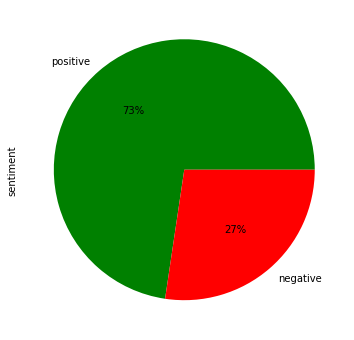

In [168]:
#distribution of sentiments across all responses
df1.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(10,6), labels= ['positive','negative'], colors=["green", "red"])
#most responses are positive

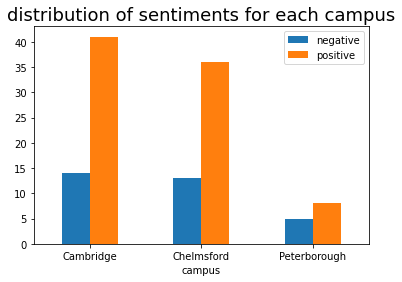

In [169]:
#distribution of sentiments for each campus
sentiment = df1.groupby(['campus', 'sentiment']).sentiment.count().unstack()
sentiment.plot(kind='bar', rot=0)
plt.title('distribution of sentiments for each campus', fontsize=18)
plt.legend(["negative", "positive"], 
           bbox_to_anchor=(1.0, 1.0), loc ="upper right")

In [170]:
#clean text

#In what ways did your Welcome Buddy help you to settle in to life as a student at ARU?

#create function that cleans the text (vocab reduction), tokenizes each word of each response and removes stop words
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
  
df1['how_helped'][2]

text = df1['how_helped'][2]

def vocab_clean(text):
    #clean text
    text = str(text)#make each entry into a string
    text = text.lower()
    text = contractions.fix(text)  #expand all contractions
    text = re.sub("[\(\[].*?[\)\]]", "", text) #remove () and [] and content inside
    text = re.sub('\w*\d\w*', '', text) #remove digits
    text = re.sub("\W"," ",text) #remove non-letters
    text = re.sub('_+', '', text) #remove underscores
    text = re.sub('-+', '', text) #remove dashes
    text = re.sub(r'[^\w\s]','',text)  #remove quotes, but not what's w/in quote
    text = text.replace('welcome buddy', '') #remove 'welcome buddy' from all responses
    text = text.replace('buddy', '') #remove 'buddy' from all responses
    text = text.replace('welcome buddies', '') #remove 'welcome buddy' from all responses
    text = text.replace('alice', '') #remove 'alice' from all responses
    text = text.replace('emma', '') #remove 'emma' from all responses
    text = text.replace('aru', '') # remove 'aru' from all responses
    text = text.replace('oh', '') # remove 'oh' from all responses
    text = text.replace(' not ', 'not_') #join all 'not' to verb preceeding it
    text = text.replace(' no ', ' no_') #join all "no" to noun following it
    #text = " ".join(re.split("\s+", text)) #remove duplicate spaces   
    #turn each element into a token
    text = word_tokenize(text)
    
    #removal of stop words
    #nltk.download('stopwords')
    stop = stopwords.words('english')
    stop.remove('not')
    stop.remove('no')
    text = [word for word in text if not word in stopwords.words()]
    
    return text

vocab_clean(text)
#apply to whole column and make this into a new column of preprocessed text
df1['new_how_helped'] = df1['how_helped'].apply(lambda x: vocab_clean(x))

In [171]:
#remove all rows that corresponded to neutral sentiment, aka clean for irrelevence
df1.dropna(inplace = True)

In [172]:
#for loop to find no of responses
count = 0
for i in df1['new_how_helped']:
    count += len(i)                    
print('Total Number of tokens : ', count)

Total Number of tokens :  660


In [173]:
tfidf = TfidfVectorizer(use_idf=True, norm='l2', smooth_idf=True)
corpus = df1['new_how_helped']

corpus = [str (item) for item in corpus]

fitted_vectorizer=tfidf.fit(corpus)
tfidf_vectorizer_vectors=fitted_vectorizer.transform(corpus)

tfidf_vectorizer_vectors.shape

(116, 340)

In [174]:
#define variables 
x = tfidf_vectorizer_vectors
x = x.toarray().astype(np.float)
y = np.array(df1.iloc[:,2])
y = y.astype(np.float)

<ipython-input-174-994aeac6577b>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.toarray().astype(np.float)
<ipython-input-174-994aeac6577b>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


In [175]:
len(x)

116

In [176]:
#split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [177]:
#check shaoe of X_train
y_train.shape

(81,)

In [178]:
#train logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
classifier = LogisticRegression()
classifier.fit(X_train, y_train)




LogisticRegression()

In [179]:
y_pred = classifier.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.77


In [180]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
# 26 correct predictions and 9 incorrect predictions

[[ 1  8]
 [ 0 26]]


In [181]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.11      0.20         9
         1.0       0.76      1.00      0.87        26

    accuracy                           0.77        35
   macro avg       0.88      0.56      0.53        35
weighted avg       0.83      0.77      0.70        35



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.897


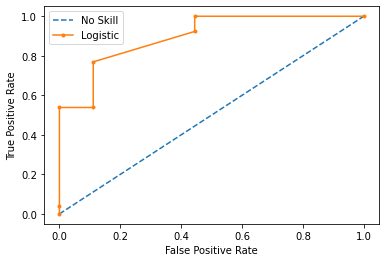

In [182]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()